# Simulate sequential fishing seasons

In [11]:
# You don't need this in normal Python, it's an IPython Notebook "magic" command
# that tells it to display matplotlib plots inline instead of in a popup
%matplotlib inline

import numpy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import random
import sys

### Utility functions

In [12]:
def sample(mu, sigma, size):
    return numpy.random.normal(loc=mu, scale=sigma, size=size)

def quota_price_per_lb(running_total_bycatch, total_quota, max_price=2.0, min_price=0.3):
    tot_avail_quota = total_quota - running_total_bycatch
    return max_price - (max_price-min_price)/total_quota * tot_avail_quota

### Function: simulate fishing season with total bycatch quota
The function below runs a simulation of a fishing season using a total quota for bycatch. After reaching this quota, the whole fishery shuts down for the season.

In [61]:
def run_season_total_quota(num_cprt, num_dfct, params):
    # Sample bycatch
    cprt_bycatch_sample = sample(params['CPRT_BYCATCH_MEAN'], 
                                 params['CPRT_BYCATCH_SPREAD'],
                                 size=(params['NUM_TIMESTEPS'], num_cprt))
    dfct_bycatch_sample = sample(params['DFCT_BYCATCH_MEAN'],
                                 params['DFCT_BYCATCH_SPREAD'],
                                 (params['NUM_TIMESTEPS'], num_dfct))
    # Sample target
    cprt_target_sample = sample(params['CPRT_TARGET_MEAN'],
                                params['CPRT_TARGET_SPREAD'],
                                (params['NUM_TIMESTEPS'], num_cprt))
    dfct_target_sample = sample(params['DFCT_TARGET_MEAN'],
                                params['DFCT_TARGET_SPREAD'],
                                (params['NUM_TIMESTEPS'], num_dfct))

    # Determine total bycatch (sum over individuals)
    total_cprt_bycatch = numpy.sum(cprt_bycatch_sample, axis=1)
    total_dfct_bycatch = numpy.sum(dfct_bycatch_sample, axis=1)
    total_bycatch = numpy.add(total_cprt_bycatch, total_dfct_bycatch)
    running_total_bycatch = numpy.cumsum(total_bycatch, axis=0)

    # Compute when quota is reached
    cumulative_over_quota = running_total_bycatch >= params['QUOTA_LIMIT']
    # The instruction below "shifts" the boolean vector indicating when
    # the fishery is over the allowed bycatch limit by one, so to allow
    # individuals to retain target harvested on the last day
    cumulative_over_quota = numpy.pad(cumulative_over_quota,(1,0), mode='constant')[:-1]
    num_open_days = numpy.sum(1-cumulative_over_quota)
    # Impose the quota limit (on group totals)
    total_cprt_target = numpy.sum(cprt_target_sample, axis=1)
    total_dfct_target = numpy.sum(dfct_target_sample, axis=1)
    # Note that the following are element-wise operations:
    # we multiply the totals for each timestep by an array of ones
    # (fishery open) and zero (fishery closed).
    # This is equivalent to using numpy.where or a list comprehension,
    # but probably a bit more efficient
    retained_cprt_target = total_cprt_target * (1-cumulative_over_quota)
    retained_dfct_target = total_dfct_target * (1-cumulative_over_quota)
    
    retained_cprt_bycatch = total_cprt_bycatch * (1-cumulative_over_quota)
    retained_dfct_bycatch = total_dfct_bycatch * (1-cumulative_over_quota)
    
    # Compute revenue
    cprt_revenue = retained_cprt_target * params['TARGET_PRICE_PER_LB'] \
            - params['TRIP_COST'] * num_cprt * (1-cumulative_over_quota)
    dfct_revenue = retained_dfct_target * params['TARGET_PRICE_PER_LB'] \
            - params['TRIP_COST'] * num_dfct * (1-cumulative_over_quota)
    
    return num_open_days, cprt_revenue, dfct_revenue, \
           retained_cprt_target, retained_dfct_target, \
           retained_cprt_bycatch, retained_dfct_bycatch

### Function: simulate fishing season with individual (and total) bycatch quota
The function below runs a simulation of a fishing season using individual and total quotas for bycatch.
After reaching her individual bycatch quota, an individual stops fishing for the season.
After reaching the total bycatch quota, the whole fishery shuts down for the season.

In [13]:
def run_season_indiv_quota(num_cprt, num_dfct, params):
    # Sample bycatch
    cprt_bycatch_sample = sample(params['CPRT_BYCATCH_MEAN'],
                                 params['CPRT_BYCATCH_SPREAD'],
                                 size=(params['NUM_TIMESTEPS'], num_cprt))
    dfct_bycatch_sample = sample(params['DFCT_BYCATCH_MEAN'],
                                 params['DFCT_BYCATCH_SPREAD'],
                                 (params['NUM_TIMESTEPS'], num_dfct))
    # Sample target
    cprt_target_sample = sample(params['CPRT_TARGET_MEAN'],
                                params['CPRT_TARGET_SPREAD'],
                                (params['NUM_TIMESTEPS'], num_cprt))
    dfct_target_sample = sample(params['DFCT_TARGET_MEAN'],
                                params['DFCT_TARGET_SPREAD'],
                                (params['NUM_TIMESTEPS'], num_dfct))

    # Apply individual quota limits
    # Note that we apply the individual quota to all individuals separately
    running_cprt_bycatch = numpy.cumsum(cprt_bycatch_sample, axis=0)
    cprt_over_quota = running_cprt_bycatch >= params['INDIVIDUAL_BYCATCH_QUOTA']
    # The following operation is needed to retain the target 
    # harvested on the day the individual went over quota
    cprt_over_quota = numpy.pad(cprt_over_quota,((1,0),(0,0)), mode='constant')[:-1, :]
    running_dfct_bycatch = numpy.cumsum(dfct_bycatch_sample, axis=0)
    dfct_over_quota = running_dfct_bycatch >= params['INDIVIDUAL_BYCATCH_QUOTA']
    dfct_over_quota = numpy.pad(dfct_over_quota,((1,0),(0,0)), mode='constant')[:-1, :]
    
    # Apply total quota limit for fishery (to retrieve shutdown date)
    total_bycatch = numpy.sum(cprt_bycatch_sample, axis=1) + \
        numpy.sum(dfct_bycatch_sample, axis=1)
    running_total_bycatch = numpy.cumsum(total_bycatch)
    total_over_quota = running_total_bycatch >= params['QUOTA_LIMIT']
    # The instruction below "shifts" the boolean vector indicating when
    # the fishery is over the allowed bycatch limit by one, so to allow
    # individuals to retain target harvested on the last day
    total_over_quota = numpy.pad(total_over_quota,(1,0), mode='constant')[:-1]
    cprt_total_over_quota_matrix = numpy.tile(
        1-(numpy.matrix(total_over_quota).transpose()), [1,num_cprt])
    dfct_total_over_quota_matrix = numpy.tile(
        1-(numpy.matrix(total_over_quota).transpose()), [1,num_dfct])
    num_open_days = numpy.sum(1-total_over_quota)
    # Impose both limits (the more strict wins: AND)
    # The instrictions below might appear a little convoluted,
    # but performing logical operations is usually
    # more efficient than going through loops...
    # Basically, we are multiplying the matrix of target samples by a matrix obtained
    # as the logical AND of two matrices, indicating whether each individual is not
    # over their quota and whether the fishery has not shut down.
    cprt_matrix_filter = numpy.logical_and(1-cprt_over_quota,
                                           cprt_total_over_quota_matrix)
    dfct_matrix_filter = numpy.logical_and(1-dfct_over_quota,
                                           dfct_total_over_quota_matrix)
    retained_cprt_target = numpy.multiply(cprt_target_sample, cprt_matrix_filter)
    retained_dfct_target = numpy.multiply(dfct_target_sample, dfct_matrix_filter)
    
    retained_cprt_bycatch = numpy.multiply(cprt_bycatch_sample, cprt_matrix_filter)
    retained_dfct_bycatch = numpy.multiply(dfct_bycatch_sample, dfct_matrix_filter)
    
    # Compute revenue
    cprt_revenue = retained_cprt_target * params['TARGET_PRICE_PER_LB'] \
            - params['TRIP_COST'] * cprt_matrix_filter
    dfct_revenue = retained_dfct_target * params['TARGET_PRICE_PER_LB'] \
            - params['TRIP_COST'] * dfct_matrix_filter
    
    return num_open_days, \
           numpy.sum(numpy.array(cprt_revenue), axis=1), \
           numpy.sum(numpy.array(dfct_revenue), axis=1), \
           numpy.sum(numpy.array(retained_cprt_target), axis=1), \
           numpy.sum(numpy.array(retained_dfct_target), axis=1), \
           numpy.sum(numpy.array(retained_cprt_bycatch), axis=1), \
           numpy.sum(numpy.array(retained_dfct_bycatch), axis=1) 

### Function: simulate fishing season with quota market
The function below runs a simulation of a fishing season using individual and total quotas for bycatch, as well as a quota market that allows individuals to buy and sell bycatch quota.

Note that the fishery's shutdown date is not directly affected by the quota market, since the shutdown date still depends on when the total quota is reached. However, the quota market alters the revenues for cooperators and defectors, which in turns affect the porportions of individuals in those group for the next season, and therefore the shutdown date as well.

This is a gargantuan function, and a lot is happening in it.

In [114]:
num_cprt = 50
num_dfct = 50

def run_season_quota_market(num_cprt, num_dfct, params):
    # Sample bycatch
    cprt_bycatch_sample = sample(params['CPRT_BYCATCH_MEAN'],
                                 params['CPRT_BYCATCH_SPREAD'],
                                 size=(params['NUM_TIMESTEPS'], num_cprt))
    dfct_bycatch_sample = sample(params['DFCT_BYCATCH_MEAN'],
                                 params['DFCT_BYCATCH_SPREAD'],
                                 (params['NUM_TIMESTEPS'], num_dfct))
    # Sample target
    cprt_target_sample = sample(params['CPRT_TARGET_MEAN'],
                                params['CPRT_TARGET_SPREAD'],
                                (params['NUM_TIMESTEPS'], num_cprt))
    dfct_target_sample = sample(params['DFCT_TARGET_MEAN'],
                                params['DFCT_TARGET_SPREAD'],
                                (params['NUM_TIMESTEPS'], num_dfct))

    # Initialize individual quotas
    cprt_indiv_quota = numpy.ones([params['NUM_TIMESTEPS'], num_cprt]) \
        * params['INDIVIDUAL_BYCATCH_QUOTA']
    dfct_indiv_quota = numpy.ones([params['NUM_TIMESTEPS'], num_dfct]) \
        * params['INDIVIDUAL_BYCATCH_QUOTA'] 

    # Compute the cumulative bycatch for both groups
    running_cprt_bycatch = numpy.cumsum(cprt_bycatch_sample, axis=0)
    running_dfct_bycatch = numpy.cumsum(dfct_bycatch_sample, axis=0)

    ###  QUOTA MARKET
    cprt_quota_need = numpy.zeros((params['NUM_TIMESTEPS'], num_cprt))
    dfct_quota_need = numpy.zeros((params['NUM_TIMESTEPS'], num_dfct))
    cprt_selling_quota = numpy.zeros((params['NUM_TIMESTEPS'], num_cprt))
    dfct_selling_quota = numpy.zeros((params['NUM_TIMESTEPS'], num_dfct))
    cprt_max_sale = numpy.ones((params['NUM_TIMESTEPS'], num_cprt)) \
        * params['%_QUOTA_FOR_SALE'] * params['INDIVIDUAL_BYCATCH_QUOTA']
    dfct_max_sale = numpy.ones((params['NUM_TIMESTEPS'], num_dfct)) \
        * params['%_QUOTA_FOR_SALE'] * params['INDIVIDUAL_BYCATCH_QUOTA']

    # Proceed timestep by timestep and try to make quota trading happen
    # (if conditions are fulfilled)
    for t in range(params['NUM_TIMESTEPS']):
        # Check if anyone needs to buy (type 1 or type 2)
        # Type 1: exceeding individual quota, and
        # Type 2: exceeding individual quota minus mean bycatch
        # (note that, strictly speaking, type 1 is a subset of type 2)
        cprt_buyers = running_cprt_bycatch[t,:] >= (cprt_indiv_quota[t,:] - params['CPRT_BYCATCH_MEAN'])
        cprt_quota_need[t,:] = params['CPRT_BYCATCH_MEAN'] \
            * cprt_buyers \
            + numpy.maximum(running_cprt_bycatch[t,:] - cprt_indiv_quota[t,:], numpy.zeros(num_cprt))
        dfct_buyers = running_dfct_bycatch[t,:] >= (dfct_indiv_quota[t,:] - params['DFCT_BYCATCH_MEAN'])
        dfct_quota_need[t,:] = params['DFCT_BYCATCH_MEAN'] \
            * dfct_buyers \
            + numpy.maximum(running_dfct_bycatch[t,:] - dfct_indiv_quota[t,:], numpy.zeros(num_dfct))
        total_quota_need = numpy.sum(cprt_quota_need[t,:]) + numpy.sum(dfct_quota_need[t,:])

        # Compute available quota to sell
        # Each individual who is not a buyer is willing to sell part of their remaining quota,
        # up to a certain percentage of the initial bycatch allowance
        cprt_sellers = (cprt_indiv_quota[t,:] - params['CPRT_BYCATCH_MEAN']) > running_cprt_bycatch[t,:]
        cprt_selling_quota[t,:] = numpy.minimum(
            numpy.maximum(
                cprt_indiv_quota[t,:] - running_cprt_bycatch[t,:],
                numpy.zeros(num_cprt)
            ),
            ### CHANGE THIS TO CHANGE THE POLICY USED FOR MAXIMUM SELLING QUOTA
            #cprt_sellers * params['%_QUOTA_FOR_SALE'] * (cprt_indiv_quota[t,:] - running_cprt_bycatch[t,:])
            cprt_sellers * cprt_max_sale[t,:]
        )

        dfct_sellers = (dfct_indiv_quota[t,:] - params['DFCT_BYCATCH_MEAN']) > running_dfct_bycatch[t,:]
        dfct_selling_quota[t,:] = numpy.minimum(
            numpy.maximum(
                dfct_indiv_quota[t,:] - running_dfct_bycatch[t,:],
                numpy.zeros(num_dfct)
            ),
            ### CHANGE THIS TO CHANGE THE POLICY USED FOR MAXIMUM SELLING QUOTA
            #dfct_sellers * params['%_QUOTA_FOR_SALE'] * (dfct_indiv_quota[t,:] - running_dfct_bycatch[t,:])
            dfct_sellers * dfct_max_sale[t,:]
        )
        total_selling_quota = numpy.sum(cprt_selling_quota[t,:]) + numpy.sum(dfct_selling_quota[t,:])

        # Concatenate the need/avail quota arrays in order to perform the trasing efficiently
        buyers = numpy.concatenate((cprt_buyers, dfct_buyers))
        quota_need = numpy.concatenate((cprt_quota_need[t,:], dfct_quota_need[t,:]))
        sellers = numpy.concatenate((cprt_sellers, dfct_sellers))
        selling_quota = numpy.concatenate((cprt_selling_quota[t,:], dfct_selling_quota[t,:]))
        indiv_quota = numpy.concatenate((cprt_indiv_quota[t,:], dfct_indiv_quota[t,:]))
        max_sale = numpy.concatenate((cprt_max_sale[t,:], dfct_max_sale[t,:]))

        # Is the total need less than the total availability?
        # If not, drop buyers at random until the condition is verified
        while total_quota_need > total_selling_quota:
            # Drop buyer with maximum quota needs
            # This maximizes the number of effective buyers
            buyer_to_drop = numpy.argmax(quota_need)
            buyers[buyer_to_drop] = 0
            quota_need[buyer_to_drop] = 0
            if sum(buyers) == 0:
                # No more buyers
                # Looks like no trade is possible (following this order)
                break
            total_quota_need = numpy.sum(quota_need[buyers])

        # Now, if possible, perform the trade.
        # This heuristics uses all available selling quota from sellers
        # in order... so it doesn't really distribute the needed quota evenly
        if 0 < total_quota_need <= total_selling_quota:
            buyers_ID = numpy.array(numpy.where(buyers))[0]
            sellers_ID = numpy.array(numpy.where(sellers))[0]
            seller_idx = 0;
            seller = sellers_ID[0]
            for buyer in buyers_ID:
                while quota_need[buyer] > 0:
                    transaction_amount = min(selling_quota[seller], quota_need[buyer])
                    selling_quota[seller] -= transaction_amount
                    quota_need[buyer] -= transaction_amount
                    indiv_quota[seller] -= transaction_amount
                    indiv_quota[buyer] += transaction_amount
                    max_sale[seller] = numpy.max(max_sale[seller]-transaction_amount, 0)
                    if selling_quota[seller] == 0:
                        seller_idx += 1
                        seller = sellers_ID[seller_idx]

            # Copy the newly available quota from the current timestep to end
            cprt_indiv_quota[t:,:] = numpy.tile(indiv_quota[:num_cprt], [params['NUM_TIMESTEPS']-t, 1])
            dfct_indiv_quota[t:,:] = numpy.tile(indiv_quota[num_cprt:], [params['NUM_TIMESTEPS']-t, 1])
            cprt_max_sale[t:,:] = numpy.tile(max_sale[:num_cprt], [params['NUM_TIMESTEPS']-t, 1])
            dfct_max_sale[t:,:] = numpy.tile(max_sale[num_cprt:], [params['NUM_TIMESTEPS']-t, 1])

    # At this point, all buying-selling has happened and the quotas
    # are fixed. We can compute how much target is retained by 
    # cooperators and defectors

    # Apply individual quota limits
    # Note that we apply the individual quota to all individuals separately
    cprt_over_quota = running_cprt_bycatch >= cprt_indiv_quota
    # The following operation is needed to retain the target 
    # harvested on the day the individual went over quota
    cprt_over_quota = numpy.pad(cprt_over_quota,((1,0),(0,0)), mode='constant')[:-1, :]
    dfct_over_quota = running_dfct_bycatch >= dfct_indiv_quota
    dfct_over_quota = numpy.pad(dfct_over_quota,((1,0),(0,0)), mode='constant')[:-1, :]

    # Apply total quota limit for fishery (to retrieve shutdown date)
    total_bycatch = numpy.sum(cprt_bycatch_sample, axis=1) + \
        numpy.sum(dfct_bycatch_sample, axis=1)
    running_total_bycatch = numpy.cumsum(total_bycatch)
    total_over_quota = running_total_bycatch >= params['QUOTA_LIMIT']
    total_over_quota = numpy.pad(total_over_quota,(1,0), mode='constant')[:-1]
    # These matrix are needed to filter target catch later
    cprt_total_over_quota_matrix = numpy.tile(
        1-(numpy.matrix(total_over_quota).transpose()), [1,num_cprt])
    dfct_total_over_quota_matrix = numpy.tile(
        1-(numpy.matrix(total_over_quota).transpose()), [1,num_dfct])
    num_open_days = numpy.sum(1-total_over_quota)

    # Impose both limits (the more strict wins: AND)
    # The instructions below might appear a little convoluted,
    # but performing logical operations is usually
    # more efficient than going through loops...
    # Basically, we are multiplying the matrix of target samples by a matrix obtained
    # as the logical AND of two matrices, indicating whether each individual is not
    # over their quota and whether the fishery has not shut down.
    cprt_matrix_filter = numpy.logical_and(1-cprt_over_quota,
                                           cprt_total_over_quota_matrix)
    dfct_matrix_filter = numpy.logical_and(1-dfct_over_quota,
                                           dfct_total_over_quota_matrix)
    retained_cprt_target = numpy.multiply(cprt_target_sample, cprt_matrix_filter)
    retained_dfct_target = numpy.multiply(dfct_target_sample, dfct_matrix_filter)
    
    retained_cprt_bycatch = numpy.multiply(cprt_bycatch_sample, cprt_matrix_filter)
    retained_dfct_bycatch = numpy.multiply(dfct_bycatch_sample, dfct_matrix_filter)

    retained_running_cprt_bycatch = numpy.multiply(running_cprt_bycatch, cprt_matrix_filter)
    retained_running_dfct_bycatch = numpy.multiply(running_dfct_bycatch, dfct_matrix_filter)
    cprt_penalty = params['PENALTY_PRICE_PER_POUND'] \
        * numpy.maximum(retained_running_cprt_bycatch - cprt_indiv_quota, 0)
    dfct_penalty = params['PENALTY_PRICE_PER_POUND'] \
        * numpy.maximum(retained_running_dfct_bycatch - dfct_indiv_quota, 0)


    # Determine the price per quota-lb throughout the season
    quota_price = numpy.apply_along_axis(quota_price_per_lb, 0, running_total_bycatch, params['QUOTA_LIMIT'])
    quota_price = quota_price * (1-total_over_quota)
    # Multiply the above with the quota bought/sold to obtain the mount of money
    # spent or gained at the quota market
    cprt_quota_diffs = numpy.vstack((numpy.zeros(num_cprt), -numpy.diff(cprt_indiv_quota, axis=0)))
    dfct_quota_diffs = numpy.vstack((numpy.zeros(num_dfct), -numpy.diff(dfct_indiv_quota, axis=0)))
    cprt_transactions = cprt_quota_diffs * numpy.tile(numpy.transpose([quota_price,]), [1, num_cprt])
    dfct_transactions = dfct_quota_diffs * numpy.tile(numpy.transpose([quota_price,]), [1, num_dfct])

    cprt_revenue = cprt_transactions - cprt_penalty \
                   + retained_cprt_target * params['TARGET_PRICE_PER_LB'] \
                   - params['TRIP_COST'] * cprt_matrix_filter
    dfct_revenue = dfct_transactions -dfct_penalty \
                   + retained_dfct_target * params['TARGET_PRICE_PER_LB'] \
                   - params['TRIP_COST'] * dfct_matrix_filter
            
    return num_open_days, \
           numpy.sum(numpy.array(cprt_revenue), axis=1), \
           numpy.sum(numpy.array(dfct_revenue), axis=1), \
           numpy.sum(numpy.array(retained_cprt_target), axis=1), \
           numpy.sum(numpy.array(retained_dfct_target), axis=1), \
           numpy.sum(numpy.array(retained_cprt_bycatch), axis=1), \
           numpy.sum(numpy.array(retained_dfct_bycatch), axis=1) 

run_season_quota_market(48, 52, params)

(42, array([  993218.31998314,   920718.97129431,   969757.99297144,
         1023707.68877332,  1014915.67882539,   994697.46549905,
          930473.25428785,  1005352.11314315,   935425.44257814,
          949691.32813468,   926436.46168755,   964045.06103083,
          983504.47988996,   961477.71853975,   991563.59649792,
         1004478.92193709,  1021060.3890466 ,  1014470.22634199,
          886340.72692471,   926561.59597753,   988111.71495923,
          910544.98133859,   996481.35802354,   915863.63054209,
         1002454.04937859,   980174.43126713,   996871.81145648,
          947606.57001758,   950964.01706158,  1018965.28771845,
          997152.25616605,  1035347.97836663,  1285775.52065889,
         1654396.63734139,  1960220.51048986,  2147810.00630043,
         2118572.91910535,  2145702.22014104,  2152903.76418171,
         2112358.11476239,   683133.63234038,   323856.94721749,
               0.        ,        0.        ,        0.        ,
               0.    

### Model parameters
The following cell contains all and only the model parameters.

In [55]:
params = dict()
params['QUOTA_LIMIT'] = 18326000*2.5
params['TRIP_COST'] = 1000
params['TARGET_PRICE_PER_LB'] = 2

params['NUM_INDIVIDUALS'] = 100
params['INDIVIDUAL_BYCATCH_QUOTA'] = \
    params['QUOTA_LIMIT'] / params['NUM_INDIVIDUALS']
    
params['NUM_CPRT_INIT'] = 60

params['NUM_SEASONS'] = 40
params['NUM_SIMULATIONS'] = 100
params['NUM_TIMESTEPS'] = 50

params['CPRT_BYCATCH_MEAN'] = 8800
params['CPRT_BYCATCH_SPREAD'] = 2444
params['DFCT_BYCATCH_MEAN'] = 13200
params['DFCT_BYCATCH_SPREAD'] = 2444
params['CPRT_TARGET_MEAN'] = 10476
params['CPRT_TARGET_SPREAD'] = 2444
params['DFCT_TARGET_MEAN'] = 11524
params['DFCT_TARGET_SPREAD'] = 2444

# Method: this can be: total_quota, indiv_quota, or quota_market (TBD)
params['METHOD'] = 'indiv_quota'

# Only needed if METHOD = 'quota_market'
params['%_QUOTA_FOR_SALE'] = 0.3
params['PENALTY_PRICE_PER_POUND'] = 2.0

### Perform simulations
The script in the cell below performs the simulations (500) over seasons.
Individuals of the group with less total revenue in the previous season switch groups with a probability proportional to such difference in revenue.

In [56]:
def run_simulation(params):
    num_cprt = numpy.zeros((params['NUM_SIMULATIONS'],
                            params['NUM_SEASONS']), dtype=int)
    num_dfct = numpy.zeros((params['NUM_SIMULATIONS'],
                            params['NUM_SEASONS']), dtype=int)

    cprt_revenue = numpy.zeros((params['NUM_SIMULATIONS'],
                                params['NUM_SEASONS']))
    dfct_revenue = numpy.zeros((params['NUM_SIMULATIONS'],
                                params['NUM_SEASONS']))
    num_open_days = numpy.zeros((params['NUM_SIMULATIONS'],
                                 params['NUM_SEASONS']))

    for season in range(params['NUM_SEASONS']):
        #print season
        #sys.stdout.flush()
        if season == 0:
            num_cprt[:,0] = params['NUM_CPRT_INIT']
            num_dfct[:,0] = params['NUM_INDIVIDUALS'] - params['NUM_CPRT_INIT']
        else:
            for sim in range(params['NUM_SIMULATIONS']):
                # Implement switch between groups
                # Note that, instead of considering each individual separately, we can sample
                # the number of switching individuals from a binomial distribution.
                # Compute probability of switching
                prev_tot_revenue = cprt_revenue[sim,season-1] + dfct_revenue[sim,season-1]
                p_switch = numpy.abs((numpy.mean(cprt_revenue[sim,season-1]) - numpy.mean(dfct_revenue[sim,season-1])) / \
                                   numpy.mean(prev_tot_revenue)) 
                #p_switch = numpy.abs((cprt_revenue[sim,season-1]  - dfct_revenue[sim,season-1]) / prev_tot_revenue)
                if numpy.mean(cprt_revenue[sim,season-1]) >= numpy.mean(dfct_revenue[sim,season-1]):
                #if cprt_revenue[sim,season-1] >= dfct_revenue[sim,season-1]:
                    # Switch only possible from DFCT to CPRT 
                    # Sample the number of defectors that switch to cooperators
                    num_cprt[sim,season] = num_cprt[sim,season-1] + \
                        numpy.random.binomial(num_dfct[sim,season-1], p_switch)
                    num_dfct[sim,season] = params['NUM_INDIVIDUALS'] - num_cprt[sim,season]
                else:
                    # Switch only possible from CPRT to DFCT 
                    # The next number of cooperators is the sum of defectors that remain defectors
                    # and the cooperators that switch
                    num_dfct[sim,season] = num_dfct[sim,season-1] + \
                        numpy.random.binomial(num_cprt[sim,season-1], p_switch)
                    num_cprt[sim,season] = params['NUM_INDIVIDUALS'] - num_dfct[sim,season]

        # For each season, project forward each simulation *individually*
        # (Each simulation is influenced by past values of same simulation only)
        for sim in range(params['NUM_SIMULATIONS']):
            # Use the method defined in the parameters to simulate the season
            if params['METHOD'] == 'total_quota':
                num_open_days[sim,season], cprt_revenue_sim, dfct_revenue_sim, _, _, _, _ = \
                    run_season_total_quota(num_cprt[sim,season], num_dfct[sim,season], params)
            elif params['METHOD'] == 'indiv_quota':
                num_open_days[sim,season], cprt_revenue_sim, dfct_revenue_sim, _, _, _, _ = \
                    run_season_indiv_quota(num_cprt[sim,season], num_dfct[sim,season], params)
            elif params['METHOD'] == 'quota_market':
                num_open_days[sim,season], cprt_revenue_sim, dfct_revenue_sim,  _, _, _, _= \
                    run_season_quota_market(num_cprt[sim,season], num_dfct[sim,season], params)

            cprt_revenue[sim,season] = numpy.sum(cprt_revenue_sim)
            dfct_revenue[sim,season] = numpy.sum(dfct_revenue_sim)
            
    return num_open_days, num_cprt, num_dfct, cprt_revenue, dfct_revenue
                

#### Plot the cumulative results of the simulations

In [57]:
def plot_sim_results(num_open_days, num_cprt, num_dfct, cprt_revenue, dfct_revenue):
    
    plt.plot(numpy.mean(cprt_revenue, 0))
    plt.plot(numpy.mean(dfct_revenue, 0))
    plt.fill_between( range(40),
                      cprt_revenue.mean(0)-cprt_revenue.std(0)/2,
                      cprt_revenue.mean(0)+cprt_revenue.std(0)/2,
                      facecolor='#dddddd',
                      linewidth=0)
    plt.fill_between( range(40),
                      dfct_revenue.mean(0)-dfct_revenue.std(0)/2,
                      dfct_revenue.mean(0)+dfct_revenue.std(0)/2,
                      facecolor='#dddddd',
                      linewidth=0)
    plt.title('Revenue over time')
    plt.ylabel('Total seasonal revenue ($)')
    plt.xlabel('Season #')
    plt.legend(['Cooperators', 'Defectors'], loc = 5)
    plt.savefig('Mult_Rev_IFQ60init_1p5to1.png')
    plt.show()

    plt.plot(numpy.mean(num_cprt, 0))
    plt.plot(numpy.mean(num_dfct, 0))
    plt.fill_between( range(40),
                      num_cprt.mean(0)-num_cprt.std(0)/2,
                      num_cprt.mean(0)+num_cprt.std(0)/2,
                      facecolor='#dddddd',
                      linewidth=0)
    plt.fill_between( range(40),
                      num_dfct.mean(0)-num_dfct.std(0)/2,
                      num_dfct.mean(0)+num_dfct.std(0)/2,
                      facecolor='#dddddd',
                      linewidth=0)
    plt.title('Cardinality of groups')
    plt.ylabel('# Individual in group')
    plt.xlabel('Season #')
    plt.legend(['Cooperators', 'Defectors'], loc = 5)
    plt.savefig('Mult_Cardinality_IFQ60init_1p5to1.png')
    plt.show()

    plt.plot(numpy.mean(num_open_days, 0))
    plt.fill_between( range(40),
                      num_open_days.mean(0)-num_open_days.std(0)/2,
                      num_open_days.mean(0)+num_open_days.std(0)/2,
                      facecolor='#dddddd',
                      linewidth=0)
    plt.title('Season length')
    plt.ylabel('# Days fishery stays open')
    plt.xlabel('Season #')
    plt.savefig('Mult_SeasonLen_IFQ60init_1p5to1.png')
    plt.show()

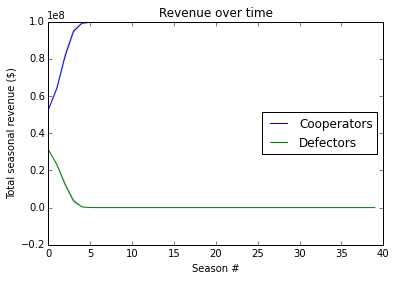

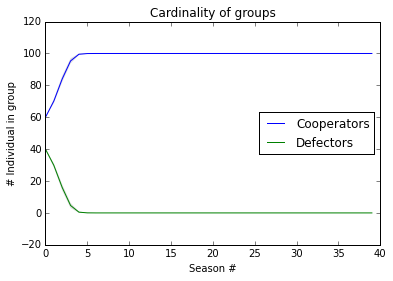

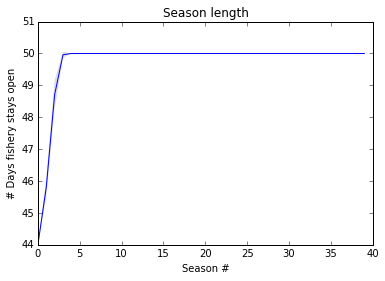

In [58]:
num_open_days, num_cprt, num_dfct, cprt_revenue, dfct_revenue = run_simulation(params)
plot_sim_results(num_open_days, num_cprt, num_dfct, cprt_revenue, dfct_revenue)

### Run multiple simulations of a season

In [59]:
num_open_days = numpy.zeros(params['NUM_SIMULATIONS'])
cprt_revenue = numpy.zeros((params['NUM_SIMULATIONS'], params['NUM_TIMESTEPS']))
dfct_revenue = numpy.zeros((params['NUM_SIMULATIONS'], params['NUM_TIMESTEPS']))
cprt_target = numpy.zeros((params['NUM_SIMULATIONS'], params['NUM_TIMESTEPS']))
dfct_target = numpy.zeros((params['NUM_SIMULATIONS'], params['NUM_TIMESTEPS']))
cprt_bycatch = numpy.zeros((params['NUM_SIMULATIONS'], params['NUM_TIMESTEPS']))
dfct_bycatch = numpy.zeros((params['NUM_SIMULATIONS'], params['NUM_TIMESTEPS']))

num_cprt = params['NUM_CPRT_INIT']
num_dfct = params['NUM_INDIVIDUALS'] - params['NUM_CPRT_INIT']

for sim in range(params['NUM_SIMULATIONS']):
    if params['METHOD'] == 'total_quota':
        sim_season_fn = run_season_total_quota
    elif params['METHOD'] == 'indiv_quota':
        sim_season_fn = run_season_indiv_quota
    else:
        sim_season_fn = run_season_quota_market
        
    num_open_days[sim], cprt_revenue[sim,:], dfct_revenue[sim,:], \
        cprt_target[sim,:], dfct_target[sim,:], cprt_bycatch[sim,:], dfct_bycatch[sim,:] = \
        sim_season_fn(num_cprt, num_dfct, params)

### Plot this results

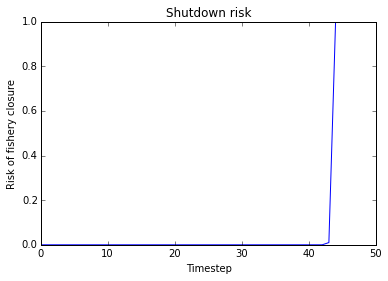

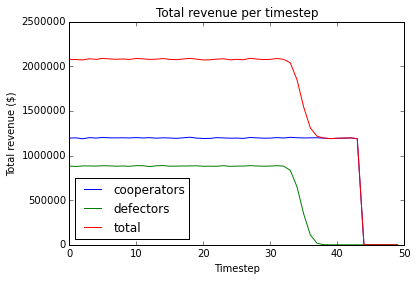

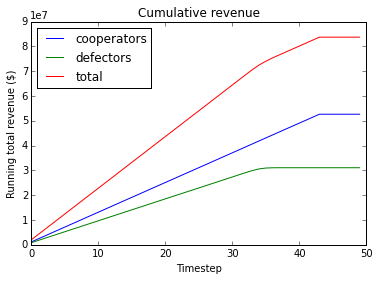

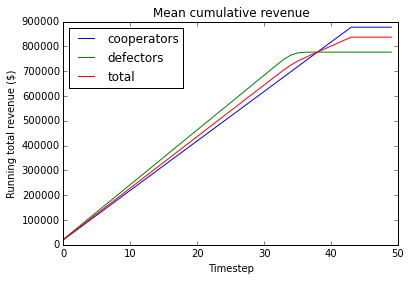

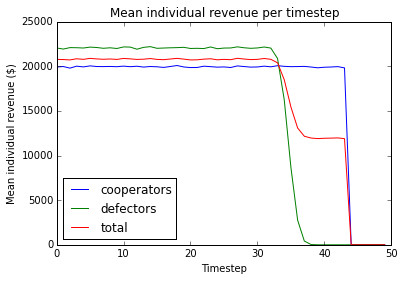

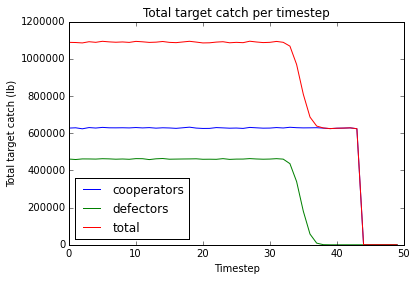

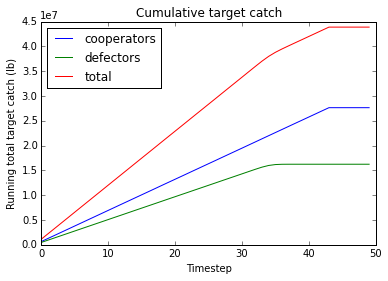

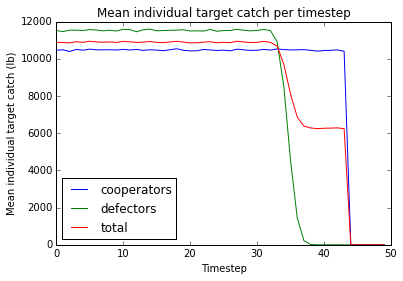

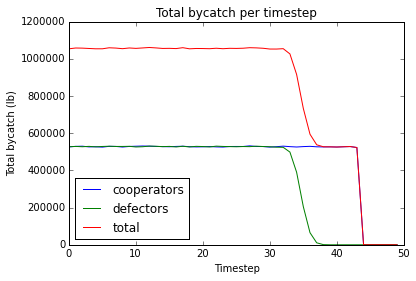

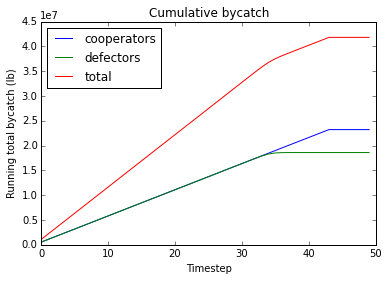

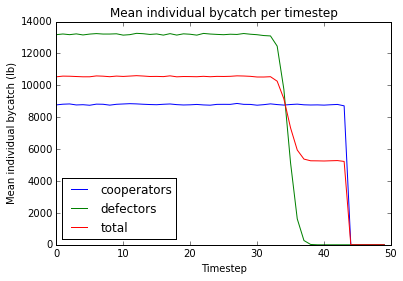

In [60]:
# Shutdown risk
shutdown_risk = numpy.mean( [range(params['NUM_TIMESTEPS']) >= x for x in num_open_days], axis=0)
_ = plt.plot(shutdown_risk)
plt.title('Shutdown risk')
plt.ylabel('Risk of fishery closure')
plt.xlabel('Timestep')
plt.savefig('1_ShutRisk_IFQ60init_1p5to1.png')
plt.show()

# Total revenue
_ = plt.plot(cprt_revenue.mean(0))
_ = plt.plot(dfct_revenue.mean(0))
_ = plt.plot(cprt_revenue.mean(0) + dfct_revenue.mean(0))
plt.legend(['cooperators', 'defectors', 'total'], loc=3)
plt.title('Total revenue per timestep')
plt.ylabel('Total revenue ($)')
plt.xlabel('Timestep')
plt.savefig('1_Rev_IFQ60init_1p5to1.png')
plt.show()

# Total cumulative revenue
_ = plt.plot(numpy.cumsum(cprt_revenue.mean(0)))
_ = plt.plot(numpy.cumsum(dfct_revenue.mean(0)))
_ = plt.plot(numpy.cumsum(cprt_revenue.mean(0) + dfct_revenue.mean(0)))
plt.legend(['cooperators', 'defectors', 'total'], loc=2)
plt.title('Cumulative revenue')
plt.ylabel('Running total revenue ($)')
plt.xlabel('Timestep')
plt.savefig('1_CumRev_IFQ60init_1p5to1.png')
plt.show()

# Mean cumulative revenue
_ = plt.plot(numpy.cumsum(cprt_revenue.mean(0))/60)
_ = plt.plot(numpy.cumsum(dfct_revenue.mean(0))/40)
_ = plt.plot(numpy.cumsum(cprt_revenue.mean(0) + dfct_revenue.mean(0))/100)
plt.legend(['cooperators', 'defectors', 'total'], loc=2)
plt.title('Mean cumulative revenue')
plt.ylabel('Running total revenue ($)')
plt.xlabel('Timestep')
plt.savefig('1_MeanCumRev_IFQ60init_1p5to1.png')
plt.show()

# Total individual revenue
_ = plt.plot(cprt_revenue.mean(0) / num_cprt)
_ = plt.plot(dfct_revenue.mean(0) / num_dfct)
_ = plt.plot((cprt_revenue.mean(0) + dfct_revenue.mean(0)) / (num_cprt+num_dfct))
plt.legend(['cooperators', 'defectors', 'total'], loc=3)
plt.title('Mean individual revenue per timestep')
plt.ylabel('Mean individual revenue ($)')
plt.xlabel('Timestep')
plt.savefig('1_MeanIndRev_IFQ60init_1p5to1.png')
plt.show()

# Total target
_ = plt.plot(cprt_target.mean(0))
_ = plt.plot(dfct_target.mean(0))
_ = plt.plot(cprt_target.mean(0) + dfct_target.mean(0))
plt.legend(['cooperators', 'defectors', 'total'], loc=3)
plt.title('Total target catch per timestep')
plt.ylabel('Total target catch (lb)')
plt.xlabel('Timestep')
plt.savefig('1_Target_IFQ60init_1p1to1.png')
plt.show()

# Total cumulative target
_ = plt.plot(numpy.cumsum(cprt_target.mean(0)))
_ = plt.plot(numpy.cumsum(dfct_target.mean(0)))
_ = plt.plot(numpy.cumsum(cprt_target.mean(0) + dfct_target.mean(0)))
plt.legend(['cooperators', 'defectors', 'total'], loc=2)
plt.title('Cumulative target catch')
plt.ylabel('Running total target catch (lb)')
plt.xlabel('Timestep')
plt.savefig('1_CumTarget_IFQ60init_1p5to1.png')
plt.show()

# Total individual target
_ = plt.plot(cprt_target.mean(0) / num_cprt)
_ = plt.plot(dfct_target.mean(0) / num_dfct)
_ = plt.plot((cprt_target.mean(0) + dfct_target.mean(0)) / (num_cprt+num_dfct))
plt.legend(['cooperators', 'defectors', 'total'], loc=3)
plt.title('Mean individual target catch per timestep')
plt.ylabel('Mean individual target catch (lb)')
plt.xlabel('Timestep')
plt.savefig('1_MeanIndTarget_IFQ60init_1p5to1.png')
plt.show()

# Total bycatch
_ = plt.plot(cprt_bycatch.mean(0))
_ = plt.plot(dfct_bycatch.mean(0))
_ = plt.plot(cprt_bycatch.mean(0) + dfct_bycatch.mean(0))
plt.legend(['cooperators', 'defectors', 'total'], loc=3)
plt.title('Total bycatch per timestep')
plt.ylabel('Total bycatch (lb)')
plt.xlabel('Timestep')
plt.savefig('1_Bycatch_IFQ60init_1p5to1.png')
plt.show()

# Total cumulative bycatch
_ = plt.plot(numpy.cumsum(cprt_bycatch.mean(0)))
_ = plt.plot(numpy.cumsum(dfct_bycatch.mean(0)))
_ = plt.plot(numpy.cumsum(cprt_bycatch.mean(0) + dfct_bycatch.mean(0)))
plt.legend(['cooperators', 'defectors', 'total'], loc=2)
plt.title('Cumulative bycatch')
plt.ylabel('Running total bycatch (lb)')
plt.xlabel('Timestep')
plt.savefig('1_CumBycatch_IFQ60init_1p5to1.png')
plt.show()

# Total individual bycatch
_ = plt.plot(cprt_bycatch.mean(0) / num_cprt)
_ = plt.plot(dfct_bycatch.mean(0) / num_dfct)
_ = plt.plot((cprt_bycatch.mean(0) + dfct_bycatch.mean(0)) / (num_cprt+num_dfct))
plt.legend(['cooperators', 'defectors', 'total'], loc=3)
plt.title('Mean individual bycatch per timestep')
plt.ylabel('Mean individual bycatch (lb)')
plt.xlabel('Timestep')
plt.savefig('1_MeanIndBycatch_IFQ60init_1p5to1.png')
plt.show()

### Run simulations across seasons for different initializations

In [44]:
range_num_cptr_init = range(30,71,5)

num_open_days = numpy.zeros((params['NUM_SIMULATIONS'], params['NUM_SEASONS'], len(range_num_cptr_init)))
num_cprt = numpy.zeros((params['NUM_SIMULATIONS'], params['NUM_SEASONS'], len(range_num_cptr_init)))
num_dfct = numpy.zeros((params['NUM_SIMULATIONS'], params['NUM_SEASONS'], len(range_num_cptr_init)))
cprt_revenue = numpy.zeros((params['NUM_SIMULATIONS'], params['NUM_SEASONS'], len(range_num_cptr_init)))
dfct_revenue = numpy.zeros((params['NUM_SIMULATIONS'], params['NUM_SEASONS'], len(range_num_cptr_init)))

for (i,x) in enumerate(range_num_cptr_init):
    print ('Initial number of cooperators: ' + str(x))
    params['NUM_CPRT_INIT'] = x
    num_open_days[:,:,i], num_cprt[:,:,i], num_dfct[:,:,i], \
        cprt_revenue[:,:,i], dfct_revenue[:,:,i] = run_simulation(params)
    #plot_sim_results(num_open_days[:,:,i], num_cprt[:,:,i], \
                 #num_dfct[:,:,i], cprt_revenue[:,:,i], dfct_revenue[:,:,i])    

Initial number of cooperators: 30
Initial number of cooperators: 35
Initial number of cooperators: 40
Initial number of cooperators: 45
Initial number of cooperators: 50
Initial number of cooperators: 55
Initial number of cooperators: 60
Initial number of cooperators: 65
Initial number of cooperators: 70


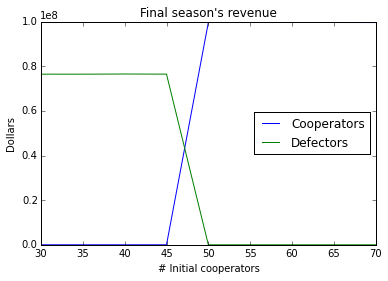

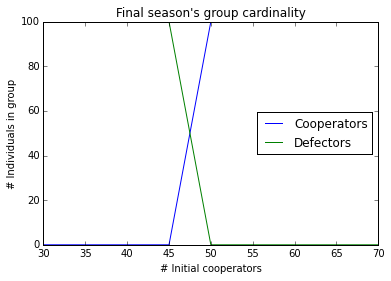

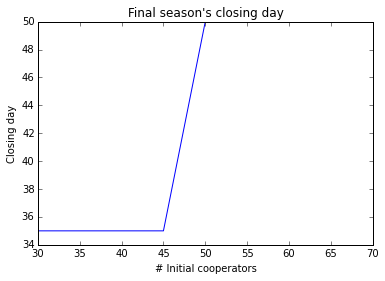

In [45]:
_ = plt.plot(range_num_cptr_init, \
             cprt_revenue[:,params['NUM_SEASONS']-1,:].mean(0), '-')
_ = plt.plot(range_num_cptr_init, \
             dfct_revenue[:,params['NUM_SEASONS']-1,:].mean(0), '-')
plt.title('Final season\'s revenue')
plt.legend(['Cooperators', 'Defectors'], loc = 7)
plt.ylabel('Dollars')
plt.xlabel('# Initial cooperators')
plt.savefig('Coop_Rev_IFQ_1p5to1.png')
plt.show()

_ = plt.plot(range_num_cptr_init, \
             num_cprt[:,params['NUM_SEASONS']-1,:].mean(0), '-')
_ = plt.plot(range_num_cptr_init, \
             num_dfct[:,params['NUM_SEASONS']-1,:].mean(0), '-')
plt.title('Final season\'s group cardinality')
plt.legend(['Cooperators', 'Defectors'], loc = 7)
plt.ylabel('# Individuals in group')
plt.xlabel('# Initial cooperators')
plt.savefig('Coop_Cardinality_IFQ_1p5to1.png')

plt.show()

_ = plt.plot(range_num_cptr_init, \
             num_open_days[:,params['NUM_SEASONS']-1,:].mean(0), '-')
plt.title('Final season\'s closing day')
plt.ylabel('Closing day')
plt.xlabel('# Initial cooperators')
plt.savefig('Coop_ClosingDay_IFQ_1p5to1.png')
plt.show()

